<a href="https://colab.research.google.com/github/yonilev2003/Proof-of-unreliability-of-casualty-data-published-by-the-Hamas-Health-Ministry/blob/main/Proof_of_Unreliability_of_Casualty_Data_Published_by_Hamas_Health_Ministry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

According to Gaza's Ministry of Health, in the first 165 days of war that commenced because of the October 7th events, more than 31,000 Palestinians in Gaza died and about 73,000 were injured. As the official body of government in Gaza, some find their data reliable. Even Israel, despite criticizing cherry-picking, data manipulation, and lying in their data, recognizes the Hamas-ruled ministry.

The following [dataset keeps track and is updated daily](https://data.techforpalestine.org/docs/casualties-daily/), presenting daily Palestinian casualty rates. I will prove the data to be manipulated and deceiving in two ways:

1. Visualizing how Hamas bluntly lied using data and over time tried to conceal their lies.

2. Statistics - calculating probabilities of the reported casualties, testing the difference in gender and between adults and children, and visualizing the manipulation Hamas tries to correct over time. In the second part of this segment, I used Benford's Law - also known as the "First-Digit Law", or the "Law of Anomalous Numbers", is a principle that states that in many sets of numerical data, the leading digit is more likely to be small. I explained this rule further and showed how the data is manipulated and deceiving below.

**The dataset:**

With data going back to the first day of the war, October 7th, 2023, kept up to date. Sources of the data are either Gaza's Ministry of Health Telegram channel or, in some days, from Gaza's Government Media Office. Both sources are viewed as official sources.

Some days no reporting was published, yet the cumulated numbers rose based on death counts from multiple fatality events, in 21 days in the first 3 months of the war. In those days, I filled the missing data with the data of casualties from multiple fatality events.

Another constraint is the distinction between children and women within the data, showing an impossible proportion of casualties. Subtracting some of the daily counts of children and women shows that more children and women were killed than the total figure of killed Gazans in those specific days. **Does it mean that you better be a man in Gaza, because their casualty rates are less than 0?** For example, on October 16th, 138 Gazans died, out of them 153 were children, and 201 were women.

Some of the days have missing data, and the dataset owners used extrapolated data using the following methodology:
* If the missing field was a cumulative one and we had an official report for a daily killed or injury count, they calculated the cumulative using the daily increment.
* If the missing field was a daily increment and they had cumulative counts, they subtracted the reported cumulative count from the prior period for the missing daily count.
* If they were missing both sets of numbers for a given reporting period, they averaged the difference between surrounding periods.

In my research, I used the extrapolated daily killed figures ('ext_killed') as they filled in the missing data using the technique I mentioned. Also, when the data was missing, they filled the cells with 0s.

**Before you go on to the project:**

134 Israeli captives are still in Gaza, even after more than 5 months of fighting. They were kidnapped by the cynical terror organization I try to discredit in this project.

I hope for their return, for their families to return to normal life, and for the war to be over soon.

# Importing & Installments

In [ ]:
# Importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import math

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Accessing the dataset
# Specifying the file path
file_path = '/content/drive/MyDrive/casualties_daily (4).csv'

# Loading the dataset using pandas
casualties = pd.read_csv(file_path)

# Looking at the first 5 rows of the dataset
casualties.head()

,report_date,report_source,ext_massacres_cum,killed,killed_cum,ext_killed,ext_killed_cum,ext_killed_children_cum,ext_killed_women_cum,injured_cum,ext_injured,ext_injured_cum,ext_civdef_killed_cum,med_killed_cum,ext_med_killed_cum,press_killed_cum,ext_press_killed_cum
0,2023-10-07,mohtel,0,232.0,232.0,232,232,0,0,1610.0,1610,1610,0,6.0,6,1.0,1
1,2023-10-08,mohtel,0,138.0,370.0,138,370,78,41,1788.0,178,1788,0,NaN,6,1.0,1
2,2023-10-09,mohtel,8,190.0,560.0,190,560,91,61,2271.0,483,2271,0,6.0,6,3.0,3
3,2023-10-10,mohtel,8,340.0,900.0,340,900,260,230,4000.0,1729,4000,0,NaN,6,7.0,7
4,2023-10-11,gmotel,23,200.0,1100.0,200,1100,398,230,5184.0,1184,5184,0,10.0,10,NaN,7


# Cleaning

In the dataset, I used the following columns:
1. report_date in DD-MM-YYY foramt.
2. report_source
3. ext_killed = the extrapolated daily fatality rate (some days extrapolated due to lack of reporting).
4. ext_killed_children_cum = extrapolated cumulative children killed (I later transformed the column into a daily count).
5. ext_killed_women_cum = extrapolated cumulative women killed (I later transformed this column as well into a daily count).

The injured reporting is not divided into women and children.

My cleaning process was the following:
* Dropping unnecessary columns.
* Checking data types and converting 'report_date' into datetime format
* Changing the 'ext_killed' column name to 'daily_killed_count' for simplicity.
* Transforming the 'ext_killed_children_cum' and 'ext_killed_women_cum' into daily counts, and called them 'daily_children_killed_count' and 'daily_women_killed_count', respectively.
* Checking if there are still missing data.
* Creating a new column 'daily_men_killed_count' and visualizing it.

In [ ]:
# Dropping unneccesary columns
# Defining the columns to keep
columns_to_keep = ['report_date', 'report_source', 'ext_killed', 'ext_killed_children_cum', 'ext_killed_women_cum']

# Dropping columns except those specified
casualties.drop(columns=casualties.columns.difference(columns_to_keep), inplace=True)

In [ ]:
# Looking at the new shape of the dataset
casualties.shape

(165, 5)

In [ ]:
# Checking the data types
casualties.dtypes

report_date                object
report_source              object
ext_killed                  int64
ext_killed_children_cum     int64
ext_killed_women_cum        int64
dtype: object

In [ ]:
# Converting 'report_date' to datetime format
casualties['report_date'] = pd.to_datetime(casualties['report_date'])

# Sorting the dataframe by 'report_date' to ensure chronological order
casualties = casualties.sort_values(by='report_date')

In [ ]:
# Changing the 'ext_killed' to 'daily_killed_counts' for simplicity
casualties.rename(columns={'ext_killed': 'daily_killed_counts'}, inplace=True)

In [ ]:
# Transforming 'ext_killed_children_cum' and 'ext_killed_women_cum' to show daily figures and changing column names to simplify
casualties['ext_killed_children_cum'] = casualties['ext_killed_children_cum'].diff().fillna(casualties['ext_killed_children_cum'])
casualties['ext_killed_women_cum'] = casualties['ext_killed_women_cum'].diff().fillna(casualties['ext_killed_women_cum'])

# Renaming columns to simplify
casualties.rename(columns={'ext_killed_children_cum': 'daily_children_killed_count',
                           'ext_killed_women_cum': 'daily_women_killed_count'}, inplace=True)

In [ ]:
# Creating a 'daily_men_killed_count' that subtracts the women and children casualties from the total daily count
casualties['daily_men_killed_count'] = casualties['daily_killed_counts'] - (casualties['daily_children_killed_count'] + casualties['daily_women_killed_count'])

In [ ]:
# Checking whether there are still missing values
casualties.isnull().sum()

report_date                    0
report_source                  0
daily_killed_counts            0
daily_children_killed_count    0
daily_women_killed_count       0
daily_men_killed_count         0
dtype: int64

In [ ]:
# Checking the first 5 rows after cleaning the data
casualties.head()

,report_date,report_source,daily_killed_counts,daily_children_killed_count,daily_women_killed_count,daily_men_killed_count
0,2023-10-07,mohtel,232,0.0,0.0,232.0
1,2023-10-08,mohtel,138,78.0,41.0,19.0
2,2023-10-09,mohtel,190,13.0,20.0,157.0
3,2023-10-10,mohtel,340,169.0,169.0,2.0
4,2023-10-11,gmotel,200,138.0,0.0,62.0


# Visualization

I made 4 visualizations in total:
1. Daily casualty rates over time, classified by children, women, and men.
2. The same thing but with **replacing negative values for men casualties with 0.**
3. Proportions between the 3 groups in the daily death count.
4. Same thing but with **replacing negative values for men casualties with 0.**

You can see that days that spike with either women or children deaths also show a negative number of adult men deaths. It's not because the people of Gaza can't count right. It's because they try to manipulate the data to show more women and children killed than in reality. The most extreme case is on December 9th, 2023, where the daily killed count is about 875 for women and -803 for men.

Over time, this "technique" is used once in a few days, and in lower frequency. It might be because Hamas wants to be strategic and prevent a case where the amount of women or children killed overall is higher than the true figures, not just in the daily cases.

Below are another 2 visualizations showing the proportion of casualties of the 3 population groups over time. Here I made 2 visualizations as well - one is "normal", and the other replaces any negative values for men with 0. Apparently, some days 100% of the casualties are men, sometimes it's 100% sometimes children are 400% of the daily casualties. Weird, isn't it?

Below, in the statistics section, I'll check how is it possible that in 165 days of war, in 75 days, 100% Of the death counts are men. I only check this group, because apparently children and women "tend" to take more than 100% in some of the daily death counts.

In [ ]:
# Visualization of death counts over time
fig_simple = px.line(casualties, x='report_date', y=['daily_children_killed_count', 'daily_women_killed_count', 'daily_men_killed_count'],
                     labels={'value': 'Daily Killed Count', 'variable': 'Group'},
                     title='Death Counts Over Time')

# Replacing negative values with 0 for the second visualization
casualties_non_negative = casualties.copy()
casualties_non_negative[['daily_children_killed_count', 'daily_women_killed_count', 'daily_men_killed_count']] = casualties_non_negative[['daily_children_killed_count', 'daily_women_killed_count', 'daily_men_killed_count']].clip(lower=0)

# Second visualization with negative values replaced by 0
fig_non_negative = px.line(casualties_non_negative, x='report_date', y=['daily_children_killed_count', 'daily_women_killed_count', 'daily_men_killed_count'],
                           labels={'value': 'Daily Killed Count', 'variable': 'Group'},
                           title='Death Counts Over Time (Negative Values Replaced with 0)')

fig_simple.show()
fig_non_negative.show()

In [ ]:
# Visualizing the proportion of each class in casualty rates in 2 visualizations - one is uninterfered, and the second replaces negative values with 0
# Preparing the data for the first visualization
casualties_data = casualties.copy()
casualties_data['daily_total_killed'] = casualties[['daily_children_killed_count', 'daily_women_killed_count', 'daily_men_killed_count']].sum(axis=1)
casualties_data['daily_percent_children'] = (casualties['daily_children_killed_count'] / casualties['daily_killed_counts']) * 100
casualties_data['daily_percent_women'] = (casualties['daily_women_killed_count'] / casualties['daily_killed_counts']) * 100
casualties_data['daily_percent_men'] = (casualties['daily_men_killed_count'] / casualties['daily_killed_counts']) * 100

# Creating the first visualization (interactive and normal)
fig_daily_percent_normal = px.line(casualties_data, x='report_date',
                                   y=['daily_percent_children', 'daily_percent_women', 'daily_percent_men'],
                                   labels={'value': 'Daily Percent', 'variable': 'Group'},
                                   title='Daily Percentages of Death Counts Over Time (Interactive)')

# Preparing the dataset for the second visualization (replacing negative values with 0)
casualties_non_negative = casualties.copy()
casualties_non_negative[['daily_children_killed_count', 'daily_women_killed_count', 'daily_men_killed_count']] = casualties_non_negative[['daily_children_killed_count', 'daily_women_killed_count', 'daily_men_killed_count']].clip(lower=0)

casualties_non_negative['daily_total_killed_non_negative'] = casualties_non_negative[['daily_children_killed_count', 'daily_women_killed_count', 'daily_men_killed_count']].sum(axis=1)
casualties_non_negative['daily_percent_children_non_negative'] = (casualties_non_negative['daily_children_killed_count'] / casualties_non_negative['daily_total_killed_non_negative']) * 100
casualties_non_negative['daily_percent_women_non_negative'] = (casualties_non_negative['daily_women_killed_count'] / casualties_non_negative['daily_total_killed_non_negative']) * 100
casualties_non_negative['daily_percent_men_non_negative'] = (casualties_non_negative['daily_men_killed_count'] / casualties_non_negative['daily_total_killed_non_negative']) * 100

# Creating the second visualization (replacing negative values with 0)
fig_daily_percent_non_negative = px.line(casualties_non_negative, x='report_date',
                                         y=['daily_percent_children_non_negative', 'daily_percent_women_non_negative', 'daily_percent_men_non_negative'],
                                         labels={'value': 'Daily Percent (Non-negative)', 'variable': 'Group (Non-negative)'},
                                         title='Daily Percentages of Death Counts Over Time (Negative Values Replaced with 0)')

fig_daily_percent_normal.show()

# Displaying the second figure separately to manage display constraints
fig_daily_percent_non_negative.show()

# Statistics

According to [Statista, the population of Gaza in 2023 is about 2.1 million people, with roughly 960,000 between the ages of 0 and 17](https://www.statista.com/topics/11678/gaza-strip/#topicOverview). I figured this number by summing up all age groups lower than 15 and dividing the number of Gaza population aged 15 and 19. This age group is 45.7% of Gaza's population.

The sex ratio, [according to The World Factbook, is about 1.03 male(s)/female](https://www.cia.gov/the-world-factbook/countries/gaza-strip/).

This means that about 45% of people in the Gaza Strip are minors, with about the same ratio of men and women.

**Descriptive statistics:**

Apparently, in at least one day, the men killed count is negative. There are only 2 possible explanations: either mistakes in the daily counts, or a deceiving technique "hidden" as an almost accidental case. In my biased opinion, Hamas tried to conceal the truth for the price of seeming fullish in data maintenance.

**Days with negative casualty rates for men:**

I calculated how many days show negative or 0 male casualties, which are 29 and 13, respectively, about a quarter of the war so far!

**Using Bayesian statistics to disprove data integrity:**

I used Bayesian statistics to test casualty rates by adult men, adult women, and children, within their proportion in the population. Children and men are slightly underrepresented, while women are slightly overrepresented.

I re-ran this test for each of the months of the war so far. The output of the test is explained further below.

As seen in the visualization and strengthened by the data, some days show "spikes" in casualties for one group over another, while looking in the monthly data shows pretty much the same proportion to their part of the population.

**Pearson coefficient:**

Pearson correlation coefficient (PCC) measures linear correlation between two quantitive variables.

In a normal context, using PCC might be irrelevant because "real-world data" should never show a correlation in casualties between the two genders. However, because I know the data is lied to and manipulated to seem as if women are prone to casualties higher than men, I was convinced this test is a good measure.

The extremely small p-value indicates that the observed correlation is highly statistically significant, meaning that women are killed much more than men according to the data.

**Checking the possibility of extreme data:**

As seen in the visualization and checked below, there are 75 days out of 165 of the given data where the number of women and children killed is 0, while there is a number different than 0 for reported men casualties.

Also, I checked the probability that men were the only casualties in up to half of the war.

Both tests show little statistical possibility:
1. The probability that all casualties in 75 out of 165 days of the war are men is 0.000000353.
2. The probability that in at least a third of the war days, all casualties were men is 5%.

**Benford's law:**

Benford's Law states that in many naturally occurring sets of numerical data, the leading significant digit is more likely to be small. In other words, smaller digits such as 1 are expected to occur more frequently as the leading digit compared to larger digits such as 2, 4, 9, etc. This law is used to diverse datasets, and disprove given data. This mechanism is used for fraud detection, data integrity verification, and forensic analysis. Elections have been proven rigged using this law, money launderers were found, and in the context of my project, I'll use it to show the cynical lack of integrity in the hands of the Gaza Health Ministry, led by Hamas.

From the visualizations below, it appears that the observed frequencies of leading digits do not completely align with the expected distribution of Benford's law.

In [ ]:
# Descriptive statistics
casualties.describe()

,daily_killed_counts,daily_children_killed_count,daily_women_killed_count,daily_men_killed_count
count,165.000000,165.000000,165.000000,165.000000
mean,192.842424,84.848485,55.878788,52.115152
std,141.262295,122.960117,105.178755,181.762791
min,0.000000,0.000000,0.000000,-886.000000
25%,104.000000,0.000000,0.000000,0.000000
50%,164.000000,0.000000,0.000000,92.000000
75%,248.000000,141.000000,96.000000,158.000000
max,828.000000,524.000000,875.000000,418.000000


In [ ]:
# Checking how many days have negative and 0 counts of men killed
# Number of days with negative counts for men
negative_counts_men_days = (casualties['daily_men_killed_count'] < 0).sum()

# Number of days with 0 counts for men
zero_counts_men_days = (casualties['daily_men_killed_count'] == 0).sum()

negative_counts_men_days, zero_counts_men_days

(29, 13)

In [ ]:
# Using Bayesian probability to calculate the chances of a man, woman, or child being killed
# Summing the otal casualties for each group
total_children_casualties = casualties['daily_children_killed_count'].sum()
total_women_casualties = casualties['daily_women_killed_count'].sum()
total_men_casualties = casualties['daily_men_killed_count'].sum()
total_casualties_overall = casualties['daily_killed_counts'].sum()

# Their population proportions
population_proportion_children = 0.45
population_proportion_women = 0.55/2
population_proportion_men = 0.55/2

# Calculating the observed proportion in casualties for Bayesian analysis
observed_proportion_children = total_children_casualties / total_casualties_overall
observed_proportion_women = total_women_casualties / total_casualties_overall
observed_proportion_men = total_men_casualties / total_casualties_overall

# Bayesian likelihood of being killed for each group, considering their part of the population
likelihood_being_killed_children = observed_proportion_children / population_proportion_children
likelihood_being_killed_women = observed_proportion_women / population_proportion_women
likelihood_being_killed_men = observed_proportion_men / population_proportion_men

likelihood_being_killed_children, likelihood_being_killed_women, likelihood_being_killed_men

(0.9777526355671489, 1.0536871909008052, 0.9827175872620417)

In [ ]:
# Re-running the test for each month separatley
# Creating a month-year string for easier grouping by month
casualties['month_year'] = casualties['report_date'].dt.to_period('M')

# Initializing a dictionary to hold the likelihoods for each month
monthly_likelihoods = {}

# Iterating through each month of interest
for month in pd.period_range(start="2023-10", end="2024-03", freq='M'):
    # Filtering the data for the current month
    current_month_data = casualties[casualties['month_year'] == month]

    # Summing up the total casualties for each group during the current month
    total_children = current_month_data['daily_children_killed_count'].sum()
    total_women = current_month_data['daily_women_killed_count'].sum()
    total_men = current_month_data['daily_men_killed_count'].sum()
    total_casualties = total_children + total_women + total_men

    # Calculating the observed proportion in casualties for the current month for Bayesian analysis
    observed_proportion_children = total_children / total_casualties if total_casualties else 0
    observed_proportion_women = total_women / total_casualties if total_casualties else 0
    observed_proportion_men = total_men / total_casualties if total_casualties else 0

    # Bayesian likelihood of being killed for each group, considering their part in the population, for the current month
    likelihood_children = observed_proportion_children / population_proportion_children if observed_proportion_children else 0
    likelihood_women = observed_proportion_women / population_proportion_women if observed_proportion_women else 0
    likelihood_men = observed_proportion_men / population_proportion_men if observed_proportion_men else 0

    # Storing the likelihoods for the current month
    monthly_likelihoods[month.strftime('%Y-%m')] = {
        'Children': likelihood_children,
        'Women': likelihood_women,
        'Men': likelihood_men
    }

monthly_likelihoods


{'2023-10': {'Children': 0.9232974910394265,
  'Women': 0.9328712343375098,
  'Men': 1.1926419621434283},
 '2023-11': {'Children': 0.9235945108455068,
  'Women': 1.0506338283230712,
  'Men': 1.0743933357479174},
 '2023-12': {'Children': 0.9335738472736479,
  'Women': 1.294632453846353,
  'Men': 0.8140648869785867},
 '2024-01': {'Children': 1.0502822633582776,
  'Women': 1.0741523147982381,
  'Men': 0.8435676178882165},
 '2024-02': {'Children': 1.2262980684033316,
  'Women': 0.9975351602145861,
  'Men': 0.6321589096708713},
 '2024-03': {'Children': 0.959142999501744,
  'Women': 0.7337953526294333,
  'Men': 1.3330615572768039}}

Bayesian test, or more broadly Bayesian analysis, describes how the probability of a hypothesis changes with new evidence.

In the context of this project, I used Bayesian analysis to determine the likelihood of different demographic groups (children, women, and men) being killed, considering their proportions in the overall population. This approach helps to identify whether certain groups are disproportionately affected by the conflict relative to their presence in the population.

By comparing the observed casualty proportions with the population proportions, a p-value over 1 means over-representation (even slightly), and vice-versa for under-representation.


Here's a breakdown of the likelihood for each month:

October 2023:
* Children: Slightly underrepresented among casualties.
* Women: Close to their population proportion, slightly overrepresented.
* Men: Significantly overrepresented among casualties.

November 2023:
* Children: Close to their population proportion, slightly overrepresented.
* Women: More significantly overrepresented than in October.
* Men: Slightly overrepresented, less so than women.

December 2023:
* Children: Underrepresented among casualties.
* Women: Significantly overrepresented, more so than in previous months.
* Men: Underrepresented, indicating a shift in the pattern observed in October and November.

January 2024:
* Children and Women: Both groups are overrepresented among casualties, with children more so than women.
* Men: Less likely to be casualties relative to their population proportion, continuing the trend from December.

February 2024:
* Children: Significantly overrepresented, indicating a higher risk of being casualties.
* Women: Close to their population proportion, indicating a balanced representation.
* Men: Significantly underrepresented among casualties, a trend that started in December 2023.

March 2024:
* Children: Close to their population proportion, slightly underrepresented.
* Women: Underrepresented among casualties.
* Men: Overrepresented, reversing the trend seen in the previous two months.

In [ ]:
# Pearson coefficient between men and women casualties, ensuring negative values are not included
pearson_r, p_value = stats.pearsonr(casualties['daily_men_killed_count'], casualties['daily_women_killed_count'])
pearson_r, p_value

(-0.6612242553862141, 4.209813196570802e-22)

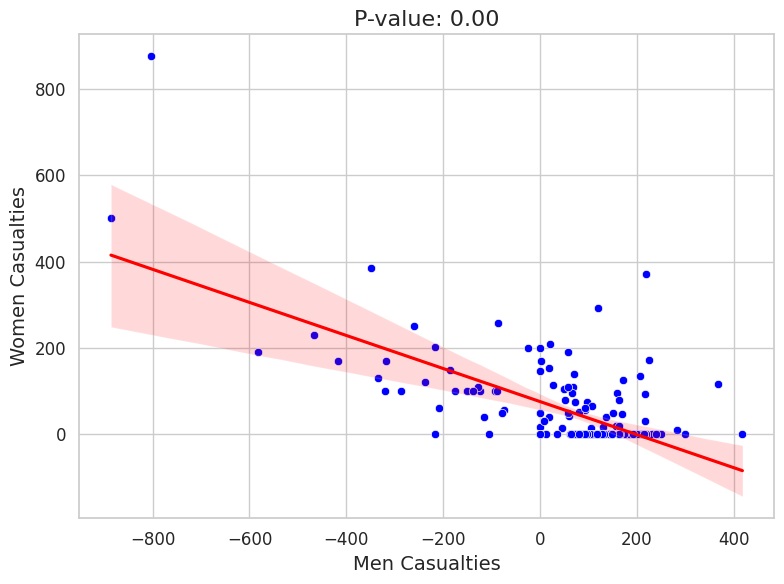

In [ ]:
# Visualizing the Pearson coefficient using scatter plot with fitted line
sns.set(style='whitegrid')
plt.figure(figsize=(8,6))
sns.scatterplot(x=casualties['daily_men_killed_count'], y=casualties['daily_women_killed_count'], color='blue')
sns.regplot(x=casualties['daily_men_killed_count'], y=casualties['daily_women_killed_count'], scatter=False, line_kws={'color': 'red'})
plt.title(f'P-value: {p_value:.2f}', fontsize=16)
plt.xlabel('Men Casualties', fontsize=14)
plt.ylabel('Women Casualties', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Checking how many days have reported men killed, with 0 women and children
# Filtering the dataset to get rows where daily_children_killed_count and daily_women_killed_count are both 0
zero_children_and_women = casualties[(casualties['daily_children_killed_count'] == 0) &
                                           (casualties['daily_women_killed_count'] == 0)]

# Furher filtering to get rows where daily_men_killed_count is different than 0
men_killed_not_zero = zero_children_and_women[zero_children_and_women['daily_men_killed_count'] != 0]

# Counting  the number of unique dates in this filtered dataset
num_days = men_killed_not_zero['report_date'].nunique()
num_days

75

In [ ]:
# Checking probability that in 75 out of 165 war days all casualties were men
n = 165 # number of total days
k = 75 # number of days where 100% of casualties are men
p = 0.275 # adult men's part of the total population

# Calculating the binomial coefficient
binomial_coefficient = math.comb(n, k)

# Calculating the probability
probability = binomial_coefficient * (p ** k) * ((1 - p) ** (n-k))
probability

3.532951231324697e-07

In [ ]:
# Checking probability that in at least 1 third of the war, all casualties were men
# Given values remain the same for n=165 and p=0.275
k = math.ceil(n / 3)

# Calculating the probability of having less than one-third of the days where all casualties are men
less_than_one_third_probability = sum(math.comb(n, k) * (p ** k) * ((1 - p) ** (n - k)) for k in range(k))

# Calculating the probability of having at least one-third of the days where all casualties are men
at_least_one_third_probability = 1 - less_than_one_third_probability
at_least_one_third_probability

0.05781767476484723

<ipython-input-140-9c990829313d>:8: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



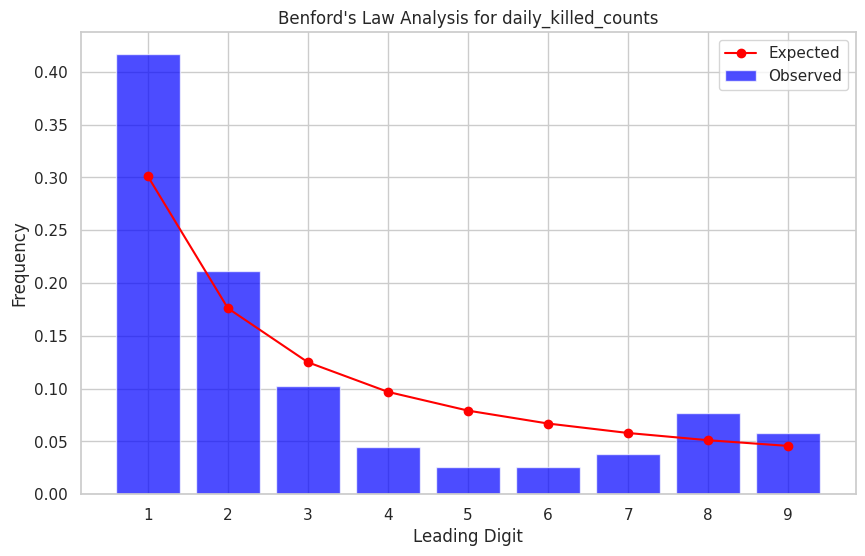

<ipython-input-140-9c990829313d>:8: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



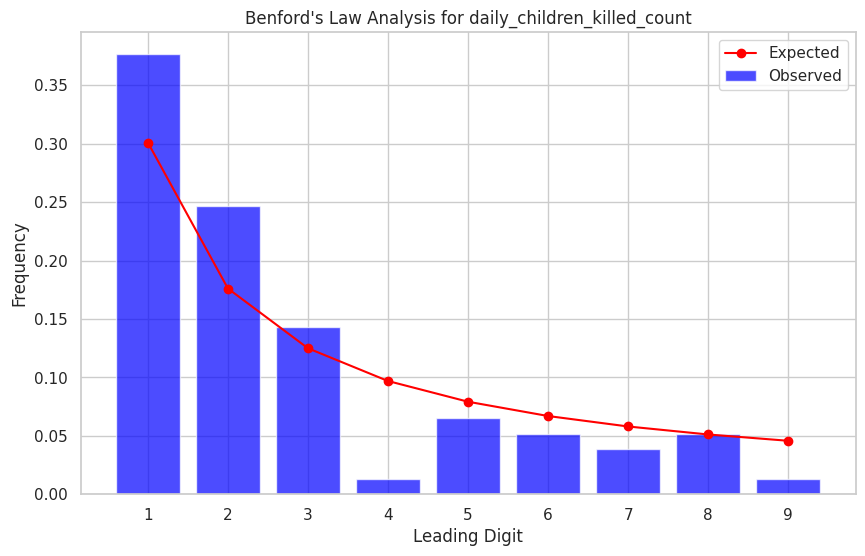

<ipython-input-140-9c990829313d>:8: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



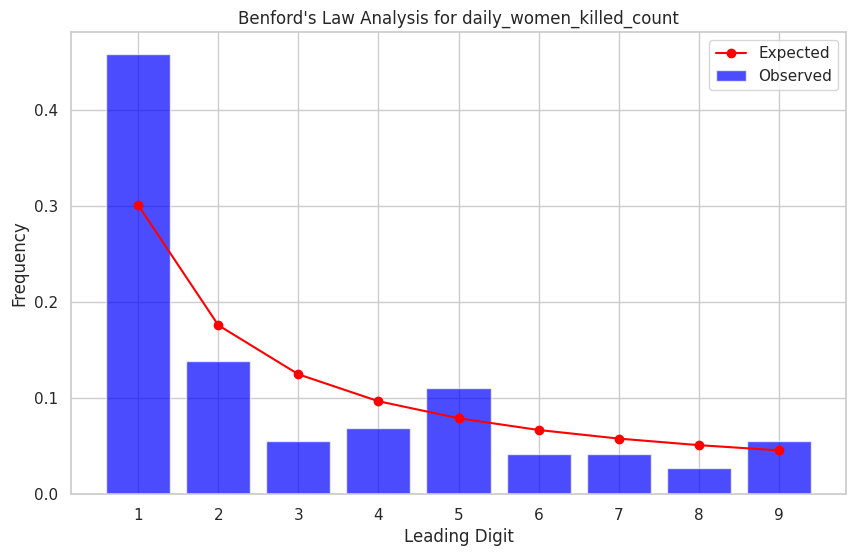

<ipython-input-140-9c990829313d>:8: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



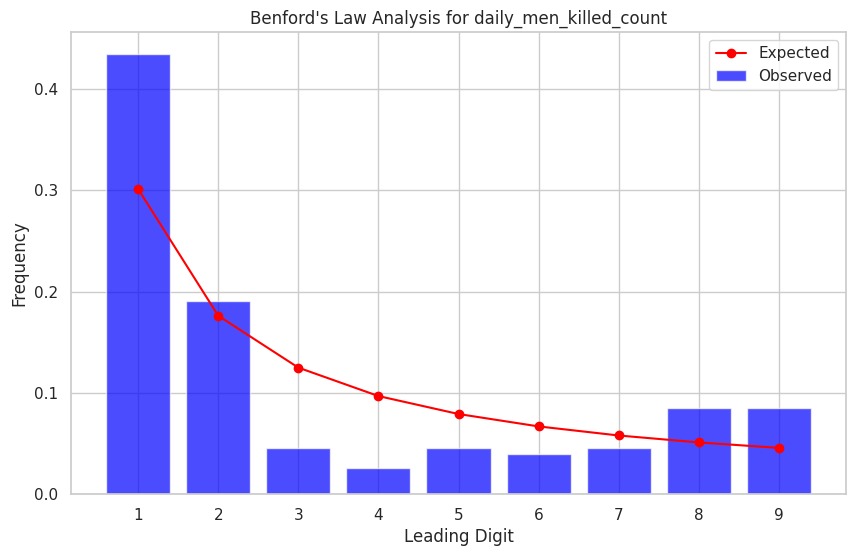

In [ ]:
# Using Benford's law to disprove the casualties data
# Defining the columns to check
columns_to_check = ['daily_killed_counts', 'daily_children_killed_count', 'daily_women_killed_count', 'daily_men_killed_count']

# Iterating over each column
for column in columns_to_check:
  # Extracting leading digits
  leading_digits = casualties[column].astype(str).str.replace('.', '').str.replace('-', '').str.lstrip('0').str[0]

  # Counting the frequency of each leading digit
  leading_digit_counts = leading_digits.value_counts(normalize=True).sort_index()

  # Expected frequencies based on Benford's law
  expected_frequencies = pd.Series([math.log10(1 + 1/digit) for digit in range(1, 10)], index=[str(digit) for digit in range(1, 10)])

  # Plottting observed vs expected frequencies for each column
  plt.figure(figsize=(10,6))
  plt.bar(leading_digit_counts.index.astype(int), leading_digit_counts, label='Observed', color='blue', alpha=0.7)
  plt.plot(expected_frequencies.index.astype(int), expected_frequencies, marker='o', linestyle='-', color='red', label='Expected')
  plt.title(f"Benford's Law Analysis for {column}")
  plt.xlabel('Leading Digit')
  plt.ylabel('Frequency')
  plt.legend()
  plt.xticks(range(1, 10))
  plt.grid(True)
  plt.show()

# In the bottom line

Ismail Haniyeh, the political leader of Hamas and the chairman of the Hamas Political Bureau, once said: "We love death like our enemies love life". It is in Hamas' interest to increase their death count, both actively and in faking the truth.

While the IDF has been doing its best to minimize Gaza population casualties, Hamas has been trying to keep Gaza during the fire as human shields.

Besides, so-called "official" organizations working in Gaza under the management of Hamas embrace lies over truth, sometimes causing contradictions in "official" data. For example, in the night between March 14th and March 15th, a 31-truck convoy from the southern to northern parts of the Gaza Strip, while thousands ran into the convoy heading to loot the trucks. Many are crushed to death by the density, and the truck drivers do not understand what goes on beyond their eyesight. The next day, about 16 hours after the event started, the Health Ministry published an official number of 38 dead, while another "official" organization, the Media Ministry, published more than 100 dead. Both organizations supposedly publish so-called "official", verified, truthful data.

Perhaps it is the organized disorganization that leads to negative death counts for men on some days. deceiving and lying, sometimes creatively, lack of truth and cynicism lies in every spot of truth left in Gaza under the leadership of Hamas.

All while the IDF guarded safe passages for Gazans because Hamas killed their people who tried to escape for shelters, while the IDF has been doing to the greatest extent to minimize casualties, and trying to run a full-scale war.

Starting this project, I planned to draw insights from the "raw data", before explaining lies and manipulation. But after a few hours of analyzing, I decided to re-structure this project to disprove from scratch how the data Hamas "crafted" is not even close to the full truth. **A government-like body responsible for their population would not play their people's lives to such a cynical and cruel extent. Behind the 32,000 reported dead people so far some real people did not want to be the price for their tirany Hamasi leaders.**